# Test 22

This notebook is intended to be ran on Servando's PC

Here the idea is to simulate different $n\times n$ sizes for different $n$

In [1]:
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib as mpl 
#mpl.use('pgf')
import matplotlib.pyplot as plt

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice

import auxiliary as aux
import montecarlo_tools as mc
import chirality_tools as chir
ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

/home/leogabac/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [3]:
quench_time = 300*ureg.s
evolution_time = 60*ureg.s
total_time = quench_time + evolution_time
data_path = "/mnt/e/rotBField/data/test22"
runs = 10

params = {
    "particle_radius":1.4*ureg.um,
    "particle_susceptibility":0.4,
    "particle_diffusion":0.14*ureg.um**2/ureg.s,
    "particle_temperature":300*ureg.K,
    "particle_density":1000*ureg.kg/ureg.m**3,

    "trap_sep":3*ureg.um,
    "trap_height":8*ureg.pN*ureg.nm,
    "trap_stiffness":100e-3*ureg.pN/ureg.nm,
    "height_spread":0,
    "susceptibility_spread":0,
    "isperiodic":True,

    "total_time":total_time,
    "framespersec":20*ureg.Hz,
    "dt":0.1*ureg.ms,
    "max_field":10*ureg.mT,
    "sim_temp":300*ureg.K,
    "sim_dipole_cutoff":40*ureg.um,
}

params["lattice_constant"] = params["trap_sep"]+(2*params["particle_radius"]+1*ureg.um)*np.sqrt(2)
#params["size"] = 10

In [4]:
def get_md_colloid(params,realization,size):
    sp = ice.spins()
    
    N = size
    a = params["lattice_constant"]
    
    # Create simulation objects
    sp.create_lattice("square",[N,N],lattice_constant=a, border="periodic")

    particle = ice.particle(radius = params["particle_radius"],
                susceptibility = params["particle_susceptibility"],
                diffusion = params["particle_diffusion"],
                temperature = params["particle_temperature"],
                density = params["particle_density"])

    trap = ice.trap(trap_sep = params["trap_sep"],
                height = params["trap_height"],
                stiffness = params["trap_stiffness"])

    col = ice.colloidal_ice(sp, particle, trap,
                            height_spread = params["height_spread"], 
                            susceptibility_spread = params["susceptibility_spread"],
                            periodic = params["isperiodic"])

        
    col.randomize()
    col.region = np.array([[0,0,-3*(params["particle_radius"]/a/N).magnitude],[1,1,3*(params["particle_radius"]/a/N).magnitude]])*N*a


    world = ice.world(
            field = params["max_field"],
            temperature = params["sim_temp"],
            dipole_cutoff = params["sim_dipole_cutoff"],
            boundaries=['p', 'p', 'p'])


    col.simulation(world,
                name = f"./lammps_files/test{realization}",
                include_timestamp = False,
                targetdir = r".",
                framerate = params["framespersec"],
                timestep = params["dt"],
                run_time = params["total_time"],
                output = ["x","y","z","mux","muy","muz"],
                processors=1)

    # Field
    

    col.sim.field.fieldx = "v_Bmag/300e6*time*(time<300e6)+v_Bmag*(time>=300e6)"
    col.sim.field.fieldy = "0"
    col.sim.field.fieldz = "0"

    col.run_simulation()

    col.load_simulation()

    return col

In [5]:
def jesus_take_the_wheels(params,data_path,size,realization):
    trj_path = data_path + "/trj/"
    ctrj_path = data_path + "/ctrj/"

    try:
        os.mkdir(trj_path)
        os.mkdir(ctrj_path)
    except:
        pass
    
    col = get_md_colloid(params,realization,size)

    filename = f"trj{realization}.csv"
    col.trj.to_csv(trj_path + filename)

    filename = f"ctrj{realization}.csv"
    trj = ice.get_ice_trj(col.trj, bounds = col.bnd)
    trj.to_csv(ctrj_path + filename)
    
    return None

# MD Shenanigans

In [6]:
import concurrent.futures

In [ ]:
size = 22
realizations = [2,3,4,5]

# Create a dir for the size
try:
    sizepath = os.path.join(data_path,str(size))
    os.mkdir(sizepath)
except:
    pass

 # Execute all the realizations for that size
with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    results = list(
        executor.map(
            jesus_take_the_wheels,
            [params] * len(realizations),
            [sizepath] * len(realizations),
            [size] * len(realizations),
            realizations,
        )
    )

In [ ]:
trj_raw = trj = pd.read_csv(os.path.join(data_path,'10','trj/trj1.csv'), index_col=[0,1])
ctrj_raw = pd.read_csv(os.path.join(data_path,'10','ctrj/ctrj1.csv'), index_col=[0,1])

fig, axes = plt.subplots(1,3,figsize=(9,2),dpi=150)

ax = axes[0]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"mux"]))
ax.set_title("$\\sim B_x$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

ax = axes[1]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muy"]))
ax.set_title("$\\sim B_y$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

ax = axes[2]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muz"]))
ax.set_title("$\\sim B_z$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

plt.show()

# Vertex counting

In [9]:
sizes = list(map(str,np.array([28,29])))
sizes

['28', '29']

In [ ]:
for strsize in sizes:
    print(f"===== size {strsize} =====")
    params['size'] = int(strsize)
    
    trj_path = os.path.join(data_path,strsize,"trj")
    ctrj_path = os.path.join(data_path,strsize,"ctrj")
    vrt_path = os.path.join(data_path,strsize,"vertices")
    
    try:
        os.mkdir(vrt_path)
    except:
        pass

    # Get the number of realizations

    for i in range(1,5+1):
        print(f"- realization {i} -")

        trj_file = os.path.join(trj_path,f"trj{i}.csv")
        print(trj_file)
        ctrj_file = os.path.join(ctrj_path,f"ctrj{i}.csv")
        vrt_file = os.path.join(vrt_path,f"vertices{i}.csv")
        
        
        if os.path.isfile(vrt_file):
            print("Already exists. Skipping")
            continue
        
        # Importing files
        try:
            trj_raw = trj = pd.read_csv(trj_file, index_col=[0,1])
            ctrj_raw = pd.read_csv(ctrj_file, index_col=[0,1])
        except:
            print("There is no such trj. Skipping")
            continue

        # Doing shit with the vertices
        v = ice.vertices()
        frames = ctrj_raw.index.get_level_values("frame").unique()

        v.trj_to_vertices(ctrj_raw.loc[frames[::20]])

        print(f"Saving vertices to " + vrt_file)
        v.vertices.to_csv(vrt_file)

        clear_output(wait=True)
    

## Analyzing vertices

In [44]:
def get_vertices_df(vrt_path, last_frame=False):
    vertices = aux.getVerticesDict(vrt_path)
    counts = aux.getVerticesCount(vertices)
    vrt_ts = aux.getVerticesAverage(counts,params["framespersec"])
    types = vrt_ts.columns.to_list()[1:]
    t = vrt_ts["time"].to_numpy()
    vrt_counts = vrt_ts[types].to_numpy()
    
    if last_frame:
        return vrt_counts[-15].tolist()
    else:
        return vrt_ts

In [45]:
vrt_paths = [os.path.join(data_path,size,'vertices') for size in os.listdir(data_path)]

In [ ]:
counts = []
for cur_size_path in vrt_paths:
    clear_output(wait=False)
    cur_counts = get_vertices_df(cur_size_path, last_frame=True)
    counts.append(cur_counts)

In [ ]:
types = ['I','II','III','IV','V','VI']
data = pd.DataFrame(np.array(counts),columns=types)
data['size'] = [int(x) for x in os.listdir(data_path)]
data

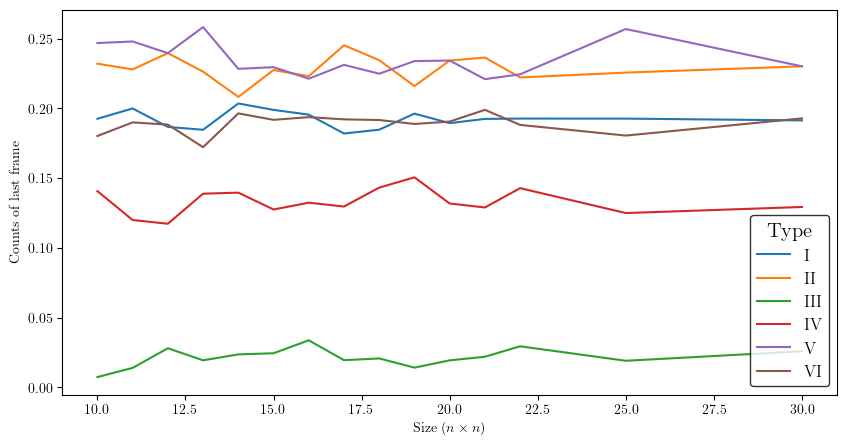

In [54]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(data['size'],data['I'])
ax.plot(data['size'],data['II'])
ax.plot(data['size'],data['III'])
ax.plot(data['size'],data['IV'])
ax.plot(data['size'],data['V'])
ax.plot(data['size'],data['VI'])

ax.legend(types, fontsize=12,title='Type', title_fontsize=15, edgecolor='black')

ax.set_xlabel('Size $(n \\times n)$')
ax.set_ylabel('Counts of last frame')

plt.show()